In [79]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq
import matplotlib.font_manager as fm
for fontInfo in fm.fontManager.ttflist :
  if 'Nanum' in fontInfo.name :
    print(fontInfo.name+ " = " + fontInfo.fname)

NanumGothic Eco = /usr/share/fonts/truetype/nanum/NanumGothicEco.ttf
NanumSquare = /usr/share/fonts/truetype/nanum/NanumSquareEB.ttf
NanumSquare = /usr/share/fonts/truetype/nanum/NanumSquareB.ttf
NanumBarunpen = /usr/share/fonts/truetype/nanum/NanumBarunpenB.ttf
Nanum Brush Script = /usr/share/fonts/truetype/nanum/NanumBrush.ttf
NanumBarunGothic = /usr/share/fonts/truetype/nanum/NanumBarunGothicUltraLight.ttf
NanumGothic Eco = /usr/share/fonts/truetype/nanum/NanumGothicEcoBold.ttf
NanumGothicCoding = /usr/share/fonts/truetype/nanum/NanumGothicCoding-Bold.ttf
NanumMyeongjo Eco = /usr/share/fonts/truetype/nanum/NanumMyeongjoEcoBold.ttf
NanumMyeongjo = /usr/share/fonts/truetype/nanum/NanumMyeongjoExtraBold.ttf
NanumSquare = /usr/share/fonts/truetype/nanum/NanumSquareR.ttf
NanumSquareRound = /usr/share/fonts/truetype/nanum/NanumSquareRoundEB.ttf
NanumBarunpen = /usr/share/fonts/truetype/nanum/NanumBarunpenR.ttf
NanumBarunGothic = /usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf
NanumSq

In [80]:
import matplotlib.font_manager as fm
fm._rebuild()

In [81]:
class EDA :
  
  def __init__(self, data = None):
    self.data = data

  def summer_feature(self):
    H = self.data['평균 상대습도(%)']
    T = self.data['평균 기온(°C)'].apply(lambda x:32 + (1.8 * x))
    temperature = -42.379 + (2.04901523*T) + (10.14333127 * H) - (0.22475541 * T * H) - (6.83783 * (10 ** -3) * (T ** 2)) - (5.481717 * (10 ** -2)*(H**2)) + (1.22874 * (10 ** -3) * (T ** 2) * H) + (8.5282 * (10 ** -4) * T * (H **2)) - (1.99 * (10**-6) * (T**2) * (H**2))    
    self.data['여름철 체감온도'] = temperature
    return self.data
  
  # 겨울철 체감온도
  def winter_feature(self):
    T = self.data['평균 기온(°C)'].apply(lambda x:32 + (1.8*x))
    V = self.data['평균 풍속(m/s)']
    temperature = 13.12 + (0.6215 * T) - (11.37 * 0.16 ** V) + (0.3965 *V *0.16**T)
    self.data['겨울철 체감온도'] = temperature
    return self.data
  # 불쾌지수 구하기
  def 불쾌지수(self):
    T = self.data['평균 기온(°C)']
    H = self.data['평균 상대습도(%)']
    불쾌지수 = (9/5 * T) - (0.55 * (1 - H/100) * ((9/5 * T) - 26)) + 32
    self.data['불쾌지수'] = 불쾌지수
    return self.data
  
  def final_dataframe(self):
    df1=EDA(self.data).summer_feature()
    df2=EDA(df1).winter_feature()
    df3=EDA(df2).불쾌지수()
    return df3

  def add_season(self) :
    df = EDA(self.data).final_dataframe()

    df.loc[(df['month'] == 12 )|(df['month'] == 1 )|(df['month'] == 2 ), 'season'] = 4
    df.loc[(df['month'] == 3 )|(df['month'] == 4 )|(df['month'] == 5 ), 'season'] = 1
    df.loc[(df['month'] == 6 )|(df['month'] == 7 )|(df['month'] == 8 ), 'season'] = 2
    df.loc[(df['month'] == 9 )|(df['month'] == 10 )|(df['month'] == 11 ), 'season'] = 3
    df['season'] = df.season.astype('int64')
    return df

  def weather_dist(self) : # 날씨 분포
    for i in self.data.columns[2:-1] :
      fig, ax = plt.subplots(figsize = (10, 5))
      sns.distplot(self.data[i])
      plt.rc('font', family='NanumGothic') 
      plt.title(f'{i}에 대한 분포')
  
  def make_season_data(self,change_featurename = '타겟이름') : # 계절 binning 후 계절별 dataframe 만들기
    

    spring = self.data.loc[(self.data['season'] == 1)].drop(['여름철 체감온도', '겨울철 체감온도'], axis = 1).rename(columns = {change_featurename : 'target'})
    summer = self.data.loc[(self.data['season'] == 2)].drop('겨울철 체감온도', axis = 1).rename(columns = {change_featurename : 'target'})
    fall = self.data.loc[(self.data['season'] == 3)].drop(['여름철 체감온도', '겨울철 체감온도'], axis = 1).rename(columns = {change_featurename : 'target'})
    winter = self.data.loc[(self.data['season'] == 4)].drop('여름철 체감온도', axis = 1).rename(columns = {change_featurename : 'target'})
    return spring, summer, fall, winter
  
  def season_dist(self,remove_feature = '관광지이름') :
    df = self.data.drop(remove_feature, axis = 1)
    for i in df.columns[2:-1] :
      fig, ax = plt.subplots(figsize = (10, 5))
      sns.distplot(self.data[i])
      plt.rc('font', family='NanumGothic') 
      plt.title(f'{i}에 대한 분포')
  
  def check_statsmodels(self,remove_feature = '관광지이름') :
    a = EDA(EDA(self.data).add_season()).make_season_data(remove_feature)
    print(a[0])
    for i in a :
      X = i.drop(['date', 'target', 'season'], axis = 1)
      y = i['target']
      X_constant = sm.add_constant(X)
      model = sm.OLS(y, X_constant)
      lin_reg = model.fit()
      print(lin_reg.summary())
      print('@'*100)



  

In [82]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

덕수궁 = pd.read_csv('/content/drive/MyDrive/project/관광지별 데이터/덕수궁.csv').drop('Unnamed: 0', axis = 1)
덕수궁

,date,month,최고 기온(°C),최소 상대습도(%),평균 기온(°C),평균 상대습도(%),일강수량(mm),평균 풍속(m/s),합계 일조 시간(hr),0.5m 지중온도(°C),최대 풍속(m/s),합계 일사량(MJ/m2),덕수궁
0,201101,1,-3.406452,35.129032,-7.183871,53.829032,1.112500,2.796774,7.048387,1.541935,5.593548,9.951290,92135
1,201102,2,5.864286,32.000000,1.221429,55.228571,9.700000,2.553571,5.950000,1.025000,5.239286,10.827857,132920
2,201103,3,8.345161,25.258065,3.616129,51.112903,2.085714,3.406452,7.748387,5.158065,6.877419,16.342258,64869
3,201104,4,15.596667,28.666667,10.720000,54.240000,10.009091,3.243333,6.736667,10.736667,6.650000,16.832333,85548
4,201105,5,22.983871,32.161290,17.925806,56.416129,4.107692,2.832258,5.819355,16.303226,6.235484,17.091935,103100
...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,201908,8,31.635484,44.645161,27.190323,68.516129,12.700000,1.590323,7.976667,26.841935,3.819355,16.766897,149905
104,201909,9,27.100000,44.133333,22.643333,65.270000,10.753846,2.183333,5.630000,24.080000,4.253333,12.892667,181790
105,201910,10,21.767742,38.935484,16.370968,62.164516,7.928571,2.129032,7.629032,19.666667,4.412903,12.755806,280107
106,201911,11,12.933333,33.133333,7.580000,55.900000,9.850000,2.166667,6.773333,12.273333,4.533333,9.476000,222529


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

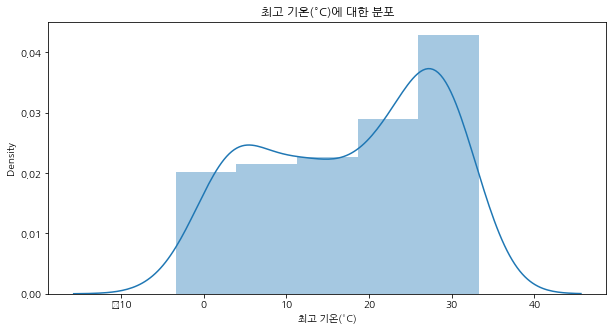

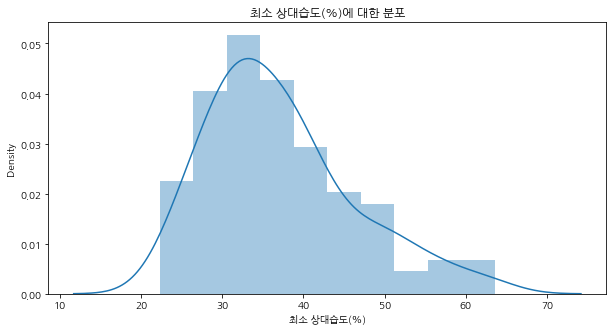

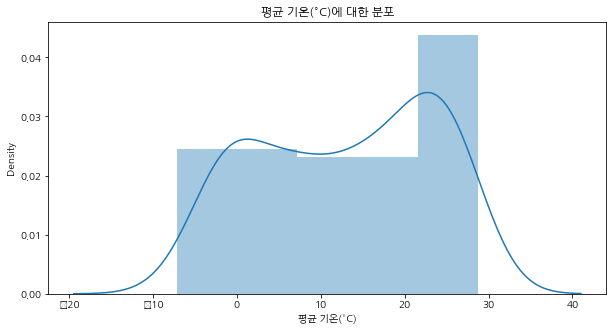

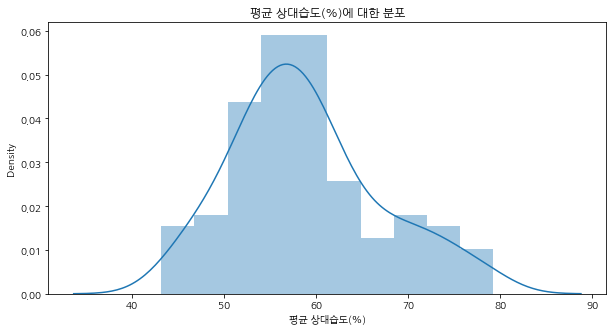

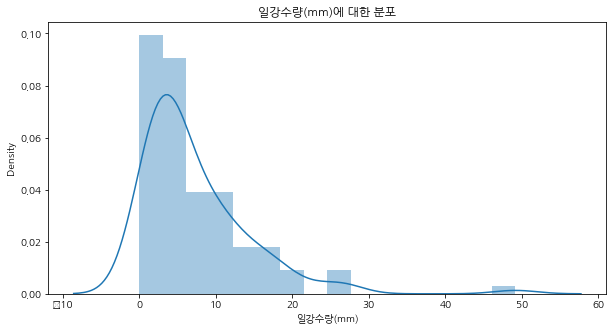

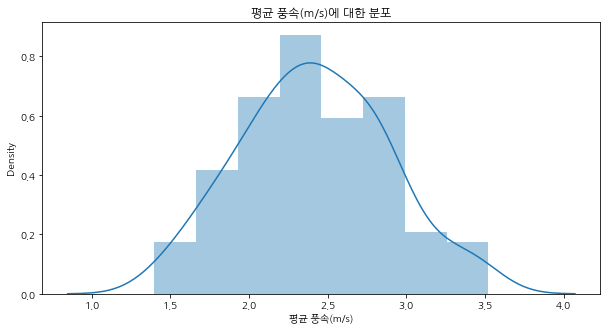

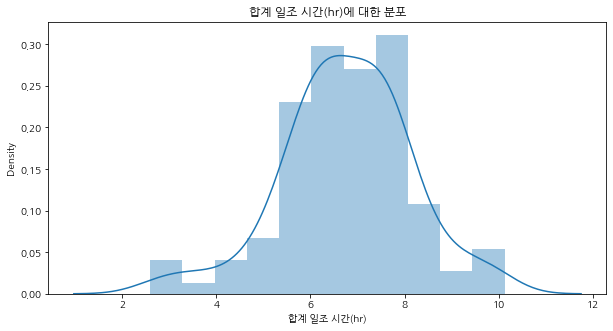

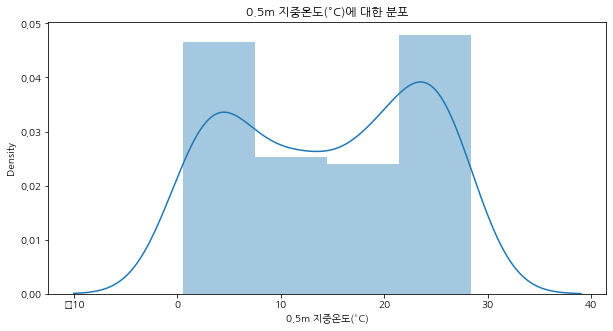

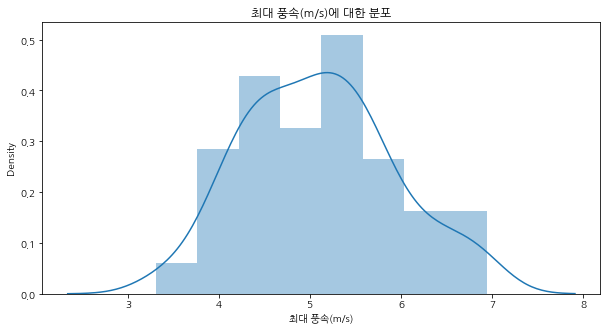

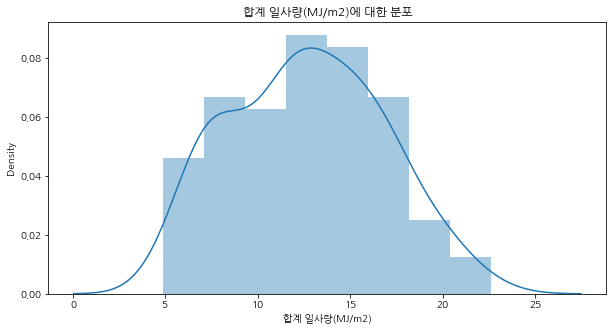

In [83]:
EDA(덕수궁).weather_dist()

In [84]:
EDA(덕수궁).add_season()

,date,month,최고 기온(°C),최소 상대습도(%),평균 기온(°C),평균 상대습도(%),일강수량(mm),평균 풍속(m/s),합계 일조 시간(hr),0.5m 지중온도(°C),최대 풍속(m/s),합계 일사량(MJ/m2),덕수궁,여름철 체감온도,겨울철 체감온도,불쾌지수,season
0,201101,1,-3.406452,35.129032,-7.183871,53.829032,1.112500,2.796774,7.048387,1.541935,5.593548,9.951290,92135,219.748397,24.903816,28.955175,4
1,201102,2,5.864286,32.000000,1.221429,55.228571,9.700000,2.553571,5.950000,1.025000,5.239286,10.827857,132920,149.419352,34.268870,40.059503,4
2,201103,3,8.345161,25.258065,3.616129,51.112903,2.085714,3.406452,7.748387,5.158065,6.877419,16.342258,64869,130.466812,37.031251,43.749745,1
3,201104,4,15.596667,28.666667,10.720000,54.240000,10.009091,3.243333,6.736667,10.736667,6.650000,16.832333,85548,96.964682,44.970648,52.983263,1
4,201105,5,22.983871,32.161290,17.925806,56.416129,4.107692,2.832258,5.819355,16.303226,6.235484,17.091935,103100,78.539731,52.998268,62.764312,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,201908,8,31.635484,44.645161,27.190323,68.516129,12.700000,1.590323,7.976667,26.841935,3.819355,16.766897,149905,84.282272,62.809141,76.969814,2
104,201909,9,27.100000,44.133333,22.643333,65.270000,10.753846,2.183333,5.630000,24.080000,4.253333,12.892667,181790,75.704768,58.131085,69.939001,3
105,201910,10,21.767742,38.935484,16.370968,62.164516,7.928571,2.129032,7.629032,19.666667,4.412903,12.755806,280107,79.758238,51.092425,60.746122,3
106,201911,11,12.933333,33.133333,7.580000,55.900000,9.850000,2.166667,6.773333,12.273333,4.533333,9.476000,222529,110.937501,41.273282,48.640948,3


In [85]:
df = EDA(덕수궁).add_season()

In [86]:
봄, 여름, 가을, 겨울 = EDA(df).make_season_data('덕수궁')
봄

,date,month,최고 기온(°C),최소 상대습도(%),평균 기온(°C),평균 상대습도(%),일강수량(mm),평균 풍속(m/s),합계 일조 시간(hr),0.5m 지중온도(°C),최대 풍속(m/s),합계 일사량(MJ/m2),target,불쾌지수,season
2,201103,3,8.345161,25.258065,3.616129,51.112903,2.085714,3.406452,7.748387,5.158065,6.877419,16.342258,64869,43.749745,1
3,201104,4,15.596667,28.666667,10.720000,54.240000,10.009091,3.243333,6.736667,10.736667,6.650000,16.832333,85548,52.983263,1
4,201105,5,22.983871,32.161290,17.925806,56.416129,4.107692,2.832258,5.819355,16.303226,6.235484,17.091935,103100,62.764312,1
14,201203,3,9.522581,28.419355,5.090323,51.845161,3.385714,3.522581,6.187097,5.300000,6.532258,11.855161,40244,45.621998,1
15,201204,4,17.886667,30.133333,12.340000,54.103333,17.444444,3.423333,7.083333,11.396667,6.940000,14.949333,66246,55.168211,1
16,201205,5,25.148387,26.838710,19.732258,48.232258,0.820000,2.651613,8.106452,19.266667,5.793548,17.851613,89515,64.808057,1
26,201303,3,10.835484,25.258065,5.135484,49.174194,3.412500,3.032258,8.267742,5.129032,6.100000,14.300323,77718,45.927912,1
27,201304,4,14.980000,28.366667,10.006667,53.976667,4.780000,3.426667,7.106667,10.133333,6.920000,14.995333,96402,52.033989,1
28,201305,5,23.587097,35.870968,18.222581,57.783871,12.000000,2.900000,7.680645,17.283871,5.861290,16.554839,103001,63.221612,1
38,201403,3,13.058065,33.032258,7.890323,59.835484,0.553846,3.029032,6.925806,7.687097,6.441935,12.646774,144903,48.808688,1


In [87]:
여름

,date,month,최고 기온(°C),최소 상대습도(%),평균 기온(°C),평균 상대습도(%),일강수량(mm),평균 풍속(m/s),합계 일조 시간(hr),0.5m 지중온도(°C),최대 풍속(m/s),합계 일사량(MJ/m2),target,여름철 체감온도,불쾌지수,season
5,201106,6,26.576667,46.233333,21.976667,66.560000,20.225000,2.923333,5.693333,21.733333,6.166667,16.424000,81489,75.030501,69.064413,2
6,201107,7,27.996774,62.419355,24.638710,78.787097,49.173913,2.419355,2.593548,24.900000,5.219355,11.042903,81544,77.605161,74.208803,2
7,201108,8,29.451613,56.290323,25.774194,74.335484,8.340000,2.522581,3.032258,26.290323,5.193548,12.222903,116552,80.764571,75.514900,2
17,201206,6,29.716667,33.000000,24.140000,54.086667,15.316667,2.800000,7.733333,24.610000,5.836667,17.815333,69169,77.784233,71.044963,2
18,201207,7,29.025806,55.935484,25.412903,73.832258,21.376190,2.729032,4.645161,25.630000,5.429032,12.101290,43076,79.760835,74.901730,2
19,201208,8,30.851613,51.000000,27.132258,67.954839,25.827778,2.967742,5.119355,27.516129,6.054839,11.704516,45103,84.021218,76.812892,2
29,201306,6,29.236667,39.700000,24.410000,60.110000,2.830000,2.230000,7.466667,23.450000,4.930000,16.914333,63520,77.962307,72.002492,2
30,201307,7,28.335484,63.548387,25.519355,79.254839,26.007692,3.351613,3.258065,25.525806,6.790323,8.660645,48941,80.167425,75.660306,2
31,201308,8,31.087097,48.935484,27.696774,69.338710,9.906667,2.774194,7.029032,27.861290,5.564516,13.566774,65233,86.025041,77.831492,2
41,201406,6,27.770000,49.066667,23.063333,72.806667,7.007143,2.603333,6.163333,22.673333,5.553333,15.513667,62932,75.058888,71.193674,2


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

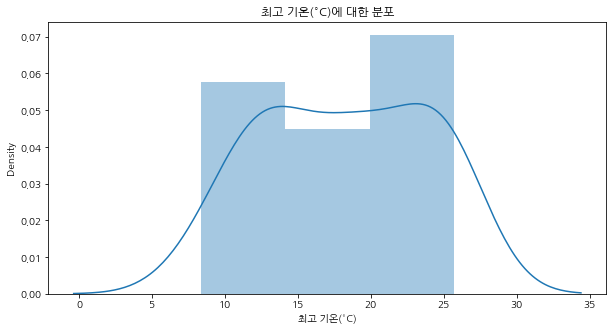

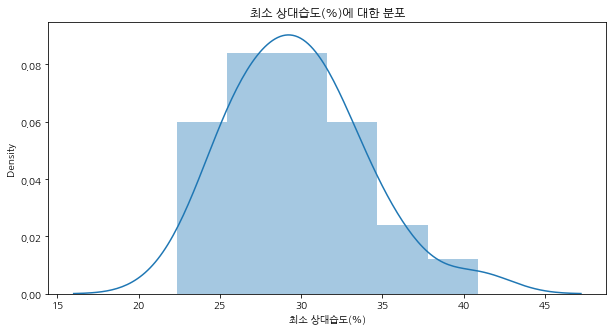

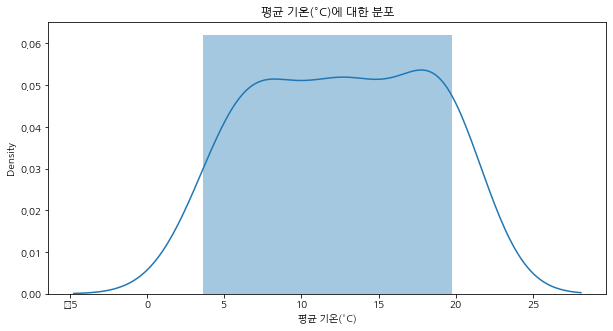

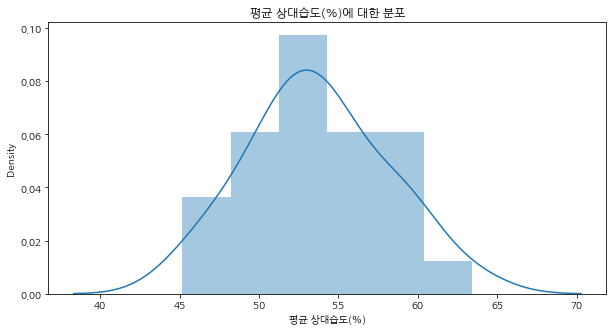

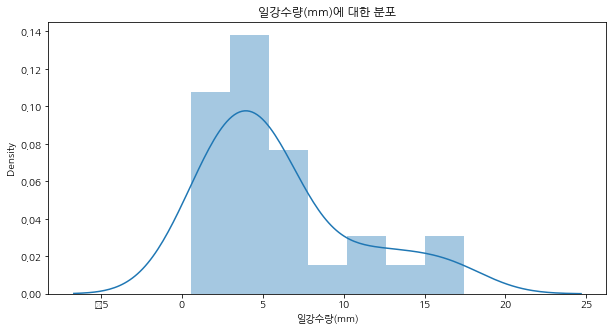

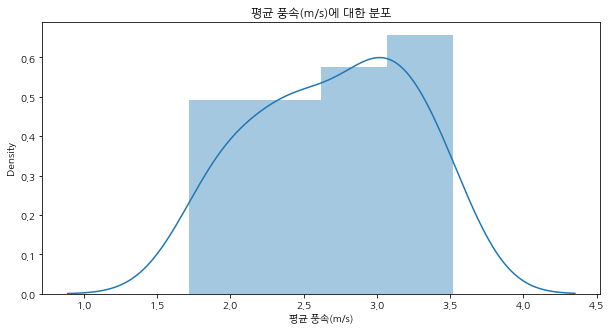

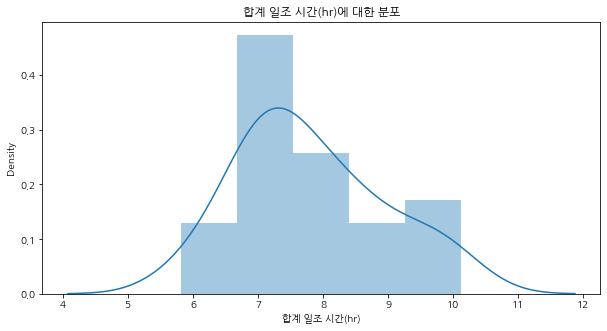

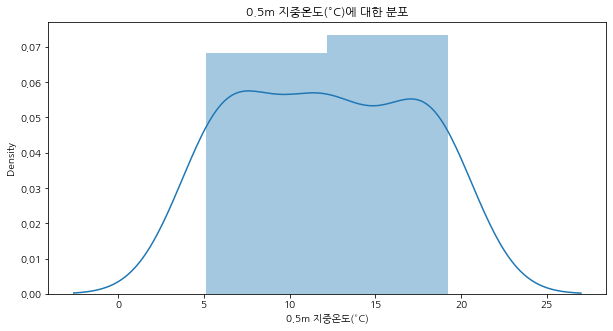

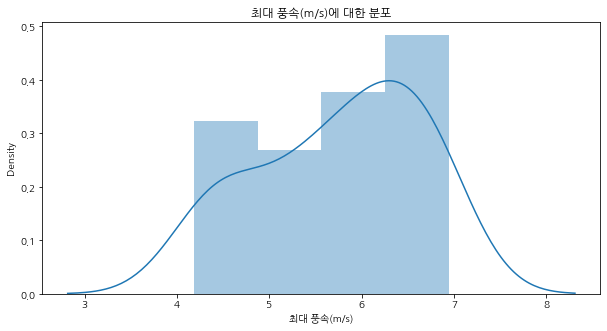

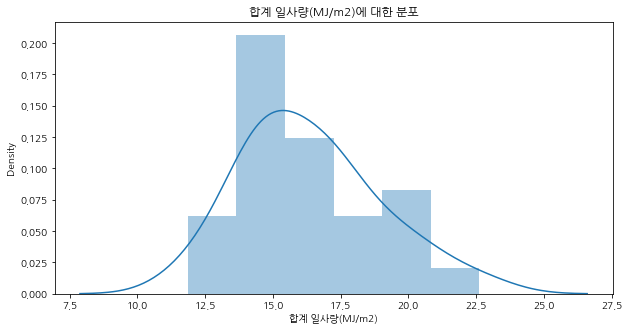

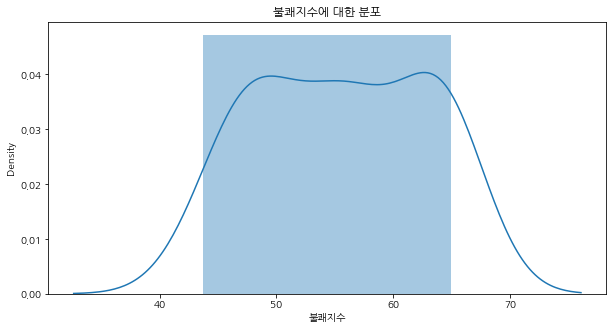

In [89]:
EDA(봄).season_dist('target')

In [90]:
EDA(덕수궁).check_statsmodels('덕수궁')

       date  month  최고 기온(°C)  ...  target       불쾌지수  season
2    201103      3   8.345161  ...   64869  43.749745       1
3    201104      4  15.596667  ...   85548  52.983263       1
4    201105      5  22.983871  ...  103100  62.764312       1
14   201203      3   9.522581  ...   40244  45.621998       1
15   201204      4  17.886667  ...   66246  55.168211       1
16   201205      5  25.148387  ...   89515  64.808057       1
26   201303      3  10.835484  ...   77718  45.927912       1
27   201304      4  14.980000  ...   96402  52.033989       1
28   201305      5  23.587097  ...  103001  63.221612       1
38   201403      3  13.058065  ...  144903  48.808688       1
39   201404      4  19.636667  ...   86252  57.325123       1
40   201405      5  25.251613  ...  100802  64.277037       1
50   201503      3  12.445161  ...   55316  47.748438       1
51   201504      4  18.826667  ...  100979  56.492757       1
52   201505      5  24.887097  ...  130874  63.915662       1
62   201